In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randn, seed
from scipy.optimize import minimize

In [2]:
raiz = r"C:\Users\cegom\Downloads"

In [3]:
market = pd.read_excel(f"{raiz}/acciones.xlsx", index_col=0)

In [4]:
R = market[["MEXBOL INDEX"]]
R = np.log(R).diff().dropna()

$$
    \sigma_t^2 = (1 - \lambda) r^2_{t-1} + \lambda \sigma_{t-1}^2
$$

In [5]:
class GARCHSigmas:
    """
    Clase para estimar sigmas para el modelo de Volatilidad Dinamica
    """
    def __init__(self, Lambda, sigma_init, R):
        self.Lambda = Lambda
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        """
        Calcula sigma_t dado datos en t - 1
        """
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = (1-self.Lambda)* rt0 ** 2 + self.Lambda * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [6]:
def LGarch(Lambda, sigma_init, R):
    
    s = GARCHSigmas(Lambda, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:]).ravel()
    r1_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum() / 2
    
    return log_likelihood

In [7]:
seed(314)
Lambda = np.abs(randn(1))
sigma_init = R.var(ddof=1).item() / 252
LGarch(Lambda, sigma_init, R)

-1333.747975676454

In [8]:
# Configuración del modelo
x0 = np.array([Lambda])
L_part = lambda x0: LGarch(*x0, sigma_init, R)

# restricción de no negativos
bounds = [
    (0, 1)
]

In [9]:
fmin = minimize(L_part, x0,
         bounds=bounds)

In [10]:
fmin

      fun: -4355.8260787813315
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00045475])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 22
      nit: 8
   status: 0
  success: True
        x: array([0.9088626])

In [11]:
Lambda_VD=fmin.x
Lambda_VD

array([0.9088626])

In [12]:
# Volatilidades sigma2
sigma0 = sigma_init
garch_predict = []
for i in range(len(R)):
    sigma0 = float((1-Lambda_VD)* R.iloc[i].item() ** 2 + Lambda_VD * sigma0)
    garch_predict.append(sigma0)

In [13]:
garch_predict

[3.7826571093125725e-05,
 3.464614856983079e-05,
 3.7875942806637596e-05,
 9.14141367927065e-05,
 9.182077391577317e-05,
 9.429157346520497e-05,
 9.114265555251855e-05,
 8.284670895750468e-05,
 8.165476543707839e-05,
 8.797516372339343e-05,
 8.319954717034232e-05,
 7.791615599268755e-05,
 7.08826737075125e-05,
 7.005888975416826e-05,
 7.465795601266737e-05,
 6.896319396305708e-05,
 7.35760984001495e-05,
 6.849670828370418e-05,
 6.634659307084285e-05,
 0.00013578226325948152,
 0.00012340742148058304,
 0.00012620510955496596,
 0.00011603498043125484,
 0.00011722974065449468,
 0.00011968846349586693,
 0.00011897569794426712,
 0.00011522405526183755,
 0.00010566508923412081,
 9.761042567375493e-05,
 8.888031069599397e-05,
 0.00011177403106382002,
 0.00010213289226046779,
 0.000104232372834132,
 9.495883381562488e-05,
 8.72692273456971e-05,
 8.073339151920008e-05,
 7.865374985375611e-05,
 7.157513871940592e-05,
 6.83581141925105e-05,
 6.220086966119841e-05,
 5.9330332665953435e-05,
 6.56907

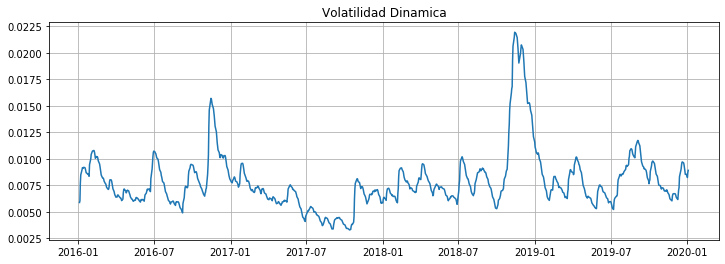

In [14]:
xaxis = R.index[1:]
sigma_garch = pd.Series(np.sqrt(garch_predict)[1:])

plt.subplots(figsize=(12, 4))
plt.title("Volatilidad Dinamica")
plt.grid()
plt.plot(xaxis, sigma_garch.ewm(2).mean());